In [1]:
import pandas as pd
import numpy as np
from gensim.models import LdaModel, CoherenceModel
from gensim import corpora
import seaborn as sns
import matplotlib.pylab as plt
from scipy.stats import pearsonr
from matplotlib.colors import ListedColormap
from scipy import stats as st

## Heatmap with signature weights

In [5]:
file = pd.read_table('/home/janneae/cns/steps/discretized_9_6bins.features', dtype=str)

In [7]:
lda = LdaModel.load(f'../steps/gensim/lda/lda_t5_f10.model')
df = file.drop(['Sample', 'Chr'], axis = 1)
listedDf = df.values.tolist()
dirichlet_dict = corpora.Dictionary(listedDf)
bow_corpus = [dirichlet_dict.doc2bow(text) for text in listedDf]

In [8]:
def create_heatmap(model, df):
    topics = lda.get_document_topics(bow = bow_corpus, minimum_probability = 0)
    
    new_df = pd.DataFrame(df['Sample'])
    new_df['Chr'] = df['Chr']
    new_df['Chr'] = pd.to_numeric(new_df['Chr'])
    
    columns = [[],[],[],[],[]]
    for topic in topics:
        for w in topic:
            columns[w[0]].append(w[1])
    
    new_df['1'] = columns[0]
    new_df['2'] = columns[1]
    new_df['3'] = columns[2]
    new_df['4'] = columns[3]
    new_df['5'] = columns[4]
    new_df = new_df.sort_values(by='Chr')
    return new_df


In [9]:
weights_df = create_heatmap(lda, file)
weights_df = weights_df[weights_df['Chr'] != 23]
heatmap_df = weights_df.drop('Sample', axis = 1).set_index('Chr').transpose()

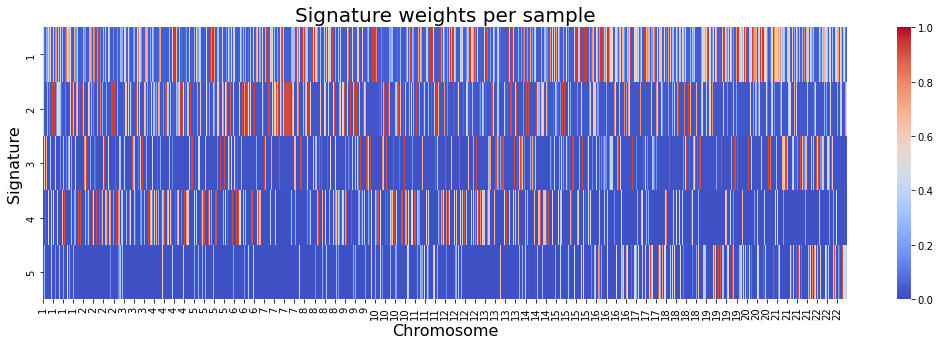

In [10]:
plt.figure(figsize=(18,5))
ax = sns.heatmap(heatmap_df, cmap='coolwarm', vmin=0, vmax=1)
ax.tick_params(axis="both", which="major", labelsize=10)
plt.xlabel('Chromosome', fontsize=16)
plt.ylabel('Signature', fontsize=16)
plt.title("Signature weights per sample", fontsize=20)
plt.savefig('../figures/heatmap.pdf')
plt.show()

## Correlating signatures with CIN variables

In [11]:
cin = pd.read_table("../data/all_tcga_cin_measures.txt", sep=" ")
cin = cin.set_index('sample_id')
cin = cin.reindex(index=weights_df['Sample'])
cin = cin.reset_index()
cin

Sample  Telomeric.AI     Mean.size  Interstitial.AI  \
0       TCGA-02-0001           6.0  1.993161e+07             18.0   
1       TCGA-AP-A054           NaN           NaN              NaN   
2       TCGA-C4-A0F7          24.0  1.787304e+07            117.0   
3       TCGA-DJ-A3US           0.0           NaN              3.0   
4       TCGA-TS-A8AI           6.0  1.943115e+07             19.0   
...              ...           ...           ...              ...   
168405  TCGA-L5-A88T           NaN           NaN              NaN   
168406  TCGA-BP-4760           0.0           NaN              1.0   
168407  TCGA-AL-3473           2.0  9.036938e+07              0.0   
168408  TCGA-GU-AATP          11.0  2.791588e+07             63.0   
168409  TCGA-L5-A88Z           6.0  6.747897e+07              1.0   

           Mean.Size  Whole.chr.AI  Telomeric.LOH  Mean.size.1  \
0       1.293457e+07           3.0            2.0   17881598.5   
1                NaN           NaN            NaN          NaN   
2       9.834940e+06           0.0           14.0   19850489.0   
3       4.811540e+06           0.0            0.0          NaN   
4       2.256094e+07           1.0            5.0   21351494.4   
...              ...           ...            ...          ...   
168405           NaN           NaN            NaN          NaN   
168406  2.749460e+06           0.0            0.0          NaN   
168407           NaN           1.0            1.0   90442517.0   
168408  8.621702e+06           1.0            4.0   32569841.0   
168409  3.282660e+06           1.0            5.0   59931290.8   

        Interstitial.LOH   Mean.Size.1  ...    Ploidy  Aberrant.cell.fraction  \
0                   11.0  1.464080e+07  ...  2.315302                    0.58   
1                    NaN           NaN  ...       NaN                     NaN   
2                   45.0  1.562689e+07  ...  3.270631                    0.62   
3                    3.0  4.811540e+06  ...  1.998908                    0.79   
4                   19.0  2.256094e+07  ...  1.790394                    0.53   
...                  ...           ...  ...       ...                     ...   
168405               NaN           NaN  ...       NaN                     NaN   
168406               1.0  2.749460e+06  ...  2.092634                    0.32   
168407               0.0           NaN  ...  2.059795                    0.34   
168408              17.0  1.031331e+07  ...  2.809372                    0.66   
168409               0.0           NaN  ...  1.925968                    0.76   

        cancerType   lst   hrd       GII      wGII      FLOH     wFLOH  \
0              NaN   9.0   6.0  0.520588  0.462361  0.201262  0.231483   
1              NaN   NaN   NaN       NaN       NaN       NaN       NaN   
2              NaN  21.0  22.0  0.704474  0.662600  0.344939  0.355221   
3              NaN   0.0   0.0  0.007034  0.004985  0.005837  0.003953   
4              NaN  12.0  13.0  0.262152  0.233425  0.254523  0.222219   
...            ...   ...   ...       ...       ...       ...       ...   
168405         NaN   NaN   NaN       NaN       NaN       NaN       NaN   
168406         NaN   0.0   0.0  0.000190  0.000273  0.001246  0.002107   
168407         NaN   1.0   3.0  0.097060  0.089527  0.064322  0.066516   
168408         NaN   8.0   4.0  0.509183  0.501556  0.154506  0.191137   
168409         NaN   0.0   4.0  0.180498  0.151298  0.120959  0.120788   

        cnt_chr  
0          52.5  
1           NaN  
2          85.0  
3          43.0  
4          41.0  
...         ...  
168405      NaN  
168406     44.0  
168407     42.5  
168408     64.5  
168409     43.0  

[168410 rows x 21 columns]

In [12]:
combined_cin = weights_df.reset_index(drop=True)
combined_cin['Telomeric.AI'] = cin['Telomeric.AI']
combined_cin['lst'] = cin['lst']
combined_cin['hrd'] = cin['hrd']
combined_cin['wGII'] = cin['wGII']
combined_cin['ploidy'] = cin['Ploidy']
combined_cin['hrd_score'] = cin['lst'] + cin['Telomeric.AI'] + cin['hrd']
combined_cin['wFLOH'] = cin['wFLOH']
combined_cin = combined_cin.dropna().reset_index(drop=True)
combined_cin

Sample  Chr         1         2         3         4         5  \
0       TCGA-02-0001    1  0.291410  0.023780  0.396947  0.014247  0.273616   
1       TCGA-C4-A0F7    1  0.037110  0.919098  0.017613  0.014241  0.011939   
2       TCGA-DJ-A3US    1  0.567111  0.388980  0.017685  0.014279  0.011946   
3       TCGA-TS-A8AI    1  0.039091  0.024253  0.017761  0.906943  0.011952   
4       TCGA-29-1711    1  0.127277  0.828753  0.017758  0.014255  0.011956   
...              ...  ...       ...       ...       ...       ...       ...   
155271  TCGA-BP-4326   22  0.044877  0.023947  0.904915  0.014311  0.011950   
155272  TCGA-BP-4760   22  0.498307  0.023580  0.017741  0.448421  0.011951   
155273  TCGA-AL-3473   22  0.768512  0.187623  0.017646  0.014265  0.011954   
155274  TCGA-GU-AATP   22  0.443454  0.023919  0.017663  0.014261  0.500703   
155275  TCGA-L5-A88Z   22  0.415360  0.024314  0.017765  0.014284  0.528276   

        Telomeric.AI   lst   hrd      wGII    ploidy  hrd_score     wFLOH  
0                6.0   9.0   6.0  0.462361  2.315302       21.0  0.231483  
1               24.0  21.0  22.0  0.662600  3.270631       67.0  0.355221  
2                0.0   0.0   0.0  0.004985  1.998908        0.0  0.003953  
3                6.0  12.0  13.0  0.233425  1.790394       31.0  0.222219  
4               28.0  32.0  20.0  0.477439  1.934815       80.0  0.420743  
...              ...   ...   ...       ...       ...        ...       ...  
155271           4.0   3.0   4.0  0.028022  1.957887       11.0  0.058627  
155272           0.0   0.0   0.0  0.000273  2.092634        0.0  0.002107  
155273           2.0   1.0   3.0  0.089527  2.059795        6.0  0.066516  
155274          11.0   8.0   4.0  0.501556  2.809372       23.0  0.191137  
155275           6.0   0.0   4.0  0.151298  1.925968       10.0  0.120788  

[155276 rows x 14 columns]

In [13]:
def correlate(cin, val):
    tel = []
    lst = []
    hrd = []
    hrd_score = []
    ploidy = []
    wGII = []
    wFLOH = []
    
    for i in range(1, 6):
        tel.append(pearsonr(cin[f'{i}'], cin['Telomeric.AI'])[val])
        lst.append(pearsonr(cin[f'{i}'], cin['lst'])[val])
        hrd.append(pearsonr(cin[f'{i}'], cin['hrd'])[val])
        hrd_score.append(pearsonr(cin[f'{i}'], cin['hrd_score'])[val])
        ploidy.append(pearsonr(cin[f'{i}'], cin['ploidy'])[val])
        wGII.append(pearsonr(cin[f'{i}'], cin['wGII'])[val])
        wFLOH.append(pearsonr(cin[f'{i}'], cin['wFLOH'])[val])
    
    corr_df = pd.DataFrame([1, 2, 3, 4, 5], columns=['Signature'])
    corr_df['Telomeric.AI'] = tel
    corr_df['LST'] = lst
    corr_df['HRD'] = hrd
    corr_df['HRD_score'] = hrd_score
    corr_df['Ploidy'] = ploidy
    corr_df['wGII'] = wGII
    corr_df['wFLOH'] = wFLOH
    
    corr_df = corr_df.set_index('Signature')
    corr_df = corr_df.transpose()
    
    return corr_df

In [14]:
corr_df = correlate(combined_cin, 0)
pval_df = correlate(combined_cin, 1)

In [15]:
psig = 0.001/176000

for i in range(1, 5):
    for j in range(1, 7):
        if pval_df[i][j] > psig:
            corr_df[i][j] = 0
corr_df

Signature            1         2         3         4         5
Telomeric.AI -0.037755  0.394413 -0.344941 -0.110110  0.084935
LST          -0.057731  0.348804 -0.294785 -0.079814  0.073809
HRD          -0.071291  0.296575 -0.277816 -0.039812  0.095970
HRD_score    -0.058074  0.383068 -0.336253 -0.088119  0.091008
Ploidy        0.181354  0.134384 -0.147190 -0.166779 -0.048657
wGII          0.062925  0.303563 -0.334189 -0.120780  0.070144
wFLOH        -0.060298  0.258639 -0.282001 -0.030768  0.130834

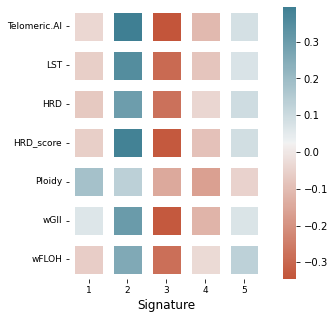

In [16]:
palette = sns.diverging_palette(20, 220, as_cmap=True)

f, ax = plt.subplots(figsize=(7, 5))
ax = sns.heatmap(
    corr_df[corr_df!=0],
    # vmin=-0.5, vmax=0.5, 
    cmap=palette,
    square=True,
    linewidths=11)
    
plt.xlabel("Signature", fontsize=12)
ax.tick_params(axis="both", which="major", labelsize=9)
plt.savefig('../figures/correlation_matrix.pdf')

## Plots

In [17]:
mutations = pd.read_table('../data/all_muts_pass_and_polyphen.txt', sep=' ')
gene_exp = pd.read_table('../data/all_tcga_gene_exp.txt', sep=' ')
maf = pd.read_table('../data/all_tcga_maf.txt', sep=' ')
cin_loc = pd.read_table('../data/cin_locations.txt')
sanchez_vega = pd.read_table('../data/sanchez_vega_pws_1026.csv', sep=';')

/scratch/64023700/ipykernel_42489/1516295756.py:1: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  mutations = pd.read_table('../data/all_muts_pass_and_polyphen.txt', sep=' ')


In [18]:
sanchez_vega

Gene   Pathway      Role    Pathway_pretty
0     EGFR  rtk_kras  Oncogene  RTK/KRAS pathway
1    ERBB2  rtk_kras  Oncogene  RTK/KRAS pathway
2    ERBB3  rtk_kras  Oncogene  RTK/KRAS pathway
3    ERBB4  rtk_kras  Oncogene  RTK/KRAS pathway
4      MET  rtk_kras  Oncogene  RTK/KRAS pathway
..     ...       ...       ...               ...
181   HEY1     notch       TSG     Notch pathway
182   HEY2     notch       TSG     Notch pathway
183   HEYL     notch       TSG     Notch pathway
184  THBS2     notch       TSG     Notch pathway
185  HDAC1     notch       NaN     Notch pathway

[186 rows x 4 columns]

In [19]:
cin_loc

Gene  Chromosome  Location         bp
1       TPX2          20   20q11.2   37024413
2       PRC1          15   15q26.1   46219718
3      FOXM1          12     12p13   48546946
4       CDC2          10   10q21.1   62205690
5   C20orf24          20  20q11.23   24891580
..       ...         ...       ...        ...
66     DHCR7          11   11q13.2  118483302
67     AURKA          20   20q13.2   43435934
68   NDUFAB1          16   16p12.1   85997352
69  KIAA0286          12   12q13.3   51686489
70     KIF4A          23    Xq13.1   46886562

[70 rows x 4 columns]

In [20]:
gene_exp

TCGA-19-1787\t"TCGA-S9-A7J2"\t"TCGA-G3-A3CH"\t"TCGA-EK-A2RE"\t"TCGA-44-6778"\t"TCGA-F4-6854"\t"TCGA-AB-2863"\t"TCGA-C8-A1HL"\t"TCGA-EW-A2FS"\t"TCGA-IR-A3L7"\t"TCGA-05-4420"\t"TCGA-R6-A8WC"\t"TCGA-DX-A3U8"\t"TCGA-GL-8500"\t"TCGA-E2-A153"\t"TCGA-BR-A4J6"\t"TCGA-EJ-7125"\t"TCGA-IN-7808"\t"TCGA-L5-A4OH"\t"TCGA-RP-A695"\t"TCGA-AX-A3G6"\t"TCGA-B9-A8YH"\t"TCGA-E1-A7YI"\t"TCGA-PC-A5DM"\t"TCGA-BR-A4QL"\t"TCGA-CH-5751"\t"TCGA-A2-A3XX"\t"TCGA-DQ-5624"\t"TCGA-KK-A7B3"\t"TCGA-DQ-7591"\t"TCGA-06-5412"\t"TCGA-BP-4989"\t"TCGA-EJ-8468"\t"TCGA-CZ-5459"\t"TCGA-D5-5538"\t"TCGA-56-8305"\t"TCGA-CZ-5468"\t"TCGA-BH-A0BQ"\t"TCGA-4X-A9FA"\t"TCGA-DD-AAW0"\t"TCGA-AA-3511"\t"TCGA-Z7-A8R5"\t"TCGA-CZ-4863"\t"TCGA-39-5031"\t"TCGA-ZG-A8QW"\t"TCGA-DU-7302"\t"TCGA-DJ-A3UX"\t"TCGA-ZN-A9VQ"\t"TCGA-EI-6512"\t"TCGA-J4-A83K"\t"TCGA-EE-A17X"\t"TCGA-HZ-7922"\t"TCGA-DD-AACA"\t"TCGA-D3-A8GD"\t"TCGA-13-1485"\t"TCGA-QG-A5YX"\t"TCGA-ZG-A9MC"\t"TCGA-DU-A7TI"\t"TCGA-A3-3335"\t"TCGA-BR-8372"\t"TCGA-HC-7742"\t"TCGA-DD-A3A6"\t"TCGA-64-1679"\t"TCGA-CV-5976"\t"TCGA-25-1315"\t"TCGA-2G-AAFZ"\t"TCGA-LN-A4MQ"\t"TCGA-CV-6948"\t"TCGA-K7-AAU7"\t"TCGA-CJ-6028"\t"TCGA-B6-A0RL"\t"TCGA-CZ-5456"\t"TCGA-EL-A3D0"\t"TCGA-EM-A22Q"\t"TCGA-49-6744"\t"TCGA-L5-A4ON"\t"TCGA-FS-A1ZF"\t"TCGA-ZN-A9VU"\t"TCGA-Q3-A5QY"\t"TCGA-AJ-A3BI"\t"TCGA-W2-A7UY"\t"TCGA-BH-A204"\t"TCGA-E3-A3E2"\t"TCGA-FB-A545"\t"TCGA-44-2657"\t"TCGA-G4-6320"\t"TCGA-EB-A41A"\t"TCGA-55-6982"\t"TCGA-RC-A7SH"\t"TCGA-CC-A3MA"\t"TCGA-DD-A3A5"\t"TCGA-RC-A7SB"\t"TCGA-CM-6164"\t"TCGA-ET-A3BW"\t"TCGA-09-0369"\t"TCGA-E2-A2P6"\t"TCGA-VD-A8KF"\t"TCGA-EL-A4JZ"\t"TCGA-M7-A722"\t"TCGA-CV-A6K0"\t"TCGA-24-1419"\t"TCGA-S6-A8JY"\t"TCGA-AO-A1KT"\t"TCGA-N9-A4Q1"\t"TCGA-12-5299"\t"TCGA-29-1761"\t"TCGA-33-4587"\t"TCGA-BJ-A0ZJ"\t"TCGA-P5-A5EX"\t"TCGA-J8-A3O2"\t"TCGA-DJ-A4V2"\t"TCGA-HT-8563"\t"TCGA-E9-A3HO"\t"TCGA-A6-A567"\t"TCGA-58-A46N"\t"TCGA-D3-A3ML"\t"TCGA-CG-4466"\t"TCGA-A3-3383"\t"TCGA-NJ-A4YI"\t"TCGA-D8-A1XJ"\t"TCGA-VT-A80J"\t"TCGA-Q1-A73Q"\t"TCGA-BQ-5880"\t"TCGA-EE-A2GB"\t"TCGA-24-1845"\t"TCGA-AA-3516"\t"TCGA-HU-A4GP"\t"TCGA-ZB-A96L"\t"TCGA-BA-6870"\t"TCGA-73-4666"\t"TCGA-MV-A51V"\t"TCGA-77-A5G6"\t"TCGA-5P-A9K4"\t"TCGA-VD-A8KE"\t"TCGA-56-A4BX"\t"TCGA-34-7107"\t"TCGA-BR-A4J9"\t"TCGA-BJ-A290"\t"TCGA-CV-6955"\t"TCGA-P3-A5Q6"\t"TCGA-FG-A60K"\t"TCGA-D7-A4Z0"\t"TCGA-24-2293"\t"TCGA-44-6146"\t"TCGA-QK-A64Z"\t"TCGA-SL-A6JA"\t"TCGA-AC-A2FK"\t"TCGA-VP-A879"\t"TCGA-29-A5NZ"\t"TCGA-CG-4462"\t"TCGA-HC-8265"\t"TCGA-37-4129"\t"TCGA-DD-AAVZ"\t"TCGA-E9-A1RF"\t"TCGA-DJ-A13R"\t"TCGA-DD-A116"\t"TCGA-E9-A1R4"\t"TCGA-3U-A98F"\t"TCGA-C5-A1MF"\t"TCGA-77-8145"\t"TCGA-LL-A740"\t"TCGA-F5-6863"\t"TCGA-06-2565"\t"TCGA-33-AASD"\t"TCGA-ET-A3BS"\t"TCGA-BH-A0BZ"\t"TCGA-22-5478"\t"TCGA-MN-A4N1"\t"TCGA-IQ-A61O"\t"TCGA-92-8063"\t"TCGA-55-7911"\t"TCGA-ED-A627"\t"TCGA-N6-A4VC"\t"TCGA-39-5028"\t"TCGA-C8-A3M8"\t"TCGA-BJ-A0ZF"\t"TCGA-BH-A0BM"\t"TCGA-AB-2914"\t"TCGA-ER-A19S"\t"TCGA-DM-A0X9"\t"TCGA-AY-A69D"\t"TCGA-AN-A0XW"\t"TCGA-55-A4DG"\t"TCGA-RW-A684"\t"TCGA-BJ-A45C"\t"TCGA-ET-A2N4"\t"TCGA-BJ-A28X"\t"TCGA-58-A46J"\t"TCGA-CV-7091"\t"TCGA-EE-A3AB"\t"TCGA-24-1426"\t"TCGA-24-1551"\t"TCGA-06-2561"\t"TCGA-KK-A8I5"\t"TCGA-IN-8663"\t"TCGA-DD-AAVV"\t"TCGA-ZJ-A8QQ"\t"TCGA-37-4133"\t"TCGA-77-8146"\t"TCGA-RL-AAAS"\t"TCGA-2G-AAHN"\t"TCGA-L9-A5IP"\t"TCGA-CJ-5672"\t"TCGA-73-4662"\t"TCGA-3U-A98I"\t"TCGA-CQ-5327"\t"TCGA-E2-A1LL"\t"TCGA-FD-A3SR"\t"TCGA-KK-A8II"\t"TCGA-B0-4700"\t"TCGA-24-1923"\t"TCGA-BH-A18K"\t"TCGA-BH-A28O"\t"TCGA-55-6712"\t"TCGA-XV-AAZW"\t"TCGA-F2-7276"\t"TCGA-BJ-A0Z2"\t"TCGA-DK-A6B0"\t"TCGA-97-7553"\t"TCGA-ET-A2N0"\t"TCGA-FB-A7DR"\t"TCGA-D3-A5GR"\t"TCGA-YB-A89D"\t"TCGA-CH-5752"\t"TCGA-77-7142"\t"TCGA-CR-7374"\t"TCGA-KS-A4I1"\t"TCGA-60-2719"\t"TCGA-VR-A8Q7"\t"TCGA-A7-A4SC"\t"TCGA-YU-A90Y"\t"TCGA-A7-A13F"\t"TCGA-ET-A2MX"\t"TCGA-FD-A5BS"\t"TCGA-IG-A3Y9"\t"TCGA-J7-6720"\t"TCGA-E9-A24A"\t"TCGA-49-AARE"\t"TCGA-BC-4073"\t"TCGA-AC-A6IV"\t"TCGA-DK-A1AD"\t"TCGA-B6-A400"\t"TCGA-EM-A2OW"\t"TCGA-XF-AAMQ"\t"TCGA-A8-A096"\t"TCGA-EM-A2OZ"\t"TCGA-WB-A816"\t"TCGA-KS-A41I"\t"TCGA-EM-A1CS"\t"TCGA-B0-5075"\t"T

In [21]:
maf

sampleID  num_mutations                   mutatated_genes  \
1     TCGA-02-0003              4          TPM3, TP53, TP53, PIK3R1   
2     TCGA-02-0033              2                      TP53, PIK3CA   
3     TCGA-02-0047              1                            PIK3CA   
4     TCGA-02-0055              2                        PTEN, TP53   
5     TCGA-02-2466              4       PTPN6, SMARCA4, LRP1B, EGFR   
...            ...            ...                               ...   
6509  TCGA-ZQ-A9CR              1                             LRP1B   
6510  TCGA-ZR-A9CJ              5  PRF1, CDH11, TP53, NFE2L2, EP300   
6511  TCGA-ZS-A9CE              1                            PIK3CA   
6512  TCGA-ZS-A9CG              2                     CTNNB1, CASP3   
6513  TCGA-ZX-AA5X              1                             EP300   

      num_tp53_high_impact_mut  have_HI_tp53  num_atm_mut  have_atm_mut  \
1                            2          True            0         False   
2                            1          True            0         False   
3                            0         False            0         False   
4                            1          True            0         False   
5                            0         False            0         False   
...                        ...           ...          ...           ...   
6509                         0         False            0         False   
6510                         1          True            0         False   
6511                         0         False            0         False   
6512                         0         False            0         False   
6513                         0         False            0         False   

      num_ifi16_mut  have_CDKN2A_mut  num_tbk1_mut  ...  have_VHL_mut  \
1                 0            False             0  ...         False   
2                 0            False             0  ...         False   
3                 0            False             0  ...         False   
4                 0            False             0  ...         False   
5                 0            False             0  ...         False   
...             ...              ...           ...  ...           ...   
6509              0            False             0  ...         False   
6510              0            False             0  ...         False   
6511              0            False             0  ...         False   
6512              0            False             0  ...         False   
6513              0            False             0  ...         False   

      have_GNAQ_mut  have_MLH1_mut  have_BUB1B_mut  have_FANCA_mut  \
1             False          False           False           False   
2             False          False           False           False   
3             False          False           False           False   
4             False          False           False           False   
5             False          False           False           False   
...             ...            ...             ...             ...   
6509          False          False           False           False   
6510          False          False           False           False   
6511          False          False           False           False   
6512          False          False           False           False   
6513          False          False           False           False   

      have_NBN_mut  have_BLM_mut  have_WRN_mut  have_sting_cgas_path_mut  \
1            False         False         False                     False   
2            False         False         False                     False   
3            False         False         False                     False   
4            False         False         False                     False   
5            False         False         False                     False   
...            ...           ...           ...                       ...   
6509  

In [119]:
high_impact = mutations[mutations['PolyPhen_num']>0.99]
gene_list = list(high_impact.drop_duplicates(subset = ["Hugo_Symbol"])['Hugo_Symbol'])

In [ ]:
mut = weights_df.reset_index(drop=True)
mut = mut.rename(columns = {'Sample': 'sampleID'})
# mut= mut.drop_duplicates(subset = ["sampleID"])
mut = pd.merge(left = mut, right = maf[['sampleID', 'mutatated_genes']], on='sampleID')

# gene_list = ['TP53', 'PTEN', 'NF1', 'MYC', 'CDK12', 'CCNE1', 'BRCA2', 'BRCA1']
# gene_list = list(cin_loc['Gene'])

for gene in gene_list:
    mut[gene] = np.where(mut['mutatated_genes'].str.contains(gene), True, False)


mut

/scratch/63863749/ipykernel_29241/1809628047.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mut[gene] = np.where(mut['mutatated_genes'].str.contains(gene), True, False)
/scratch/63863749/ipykernel_29241/1809628047.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  mut[gene] = np.where(mut['mutatated_genes'].str.contains(gene), True, False)
/scratch/63863749/ipykernel_29241/1809628047.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor

In [ ]:
sig = [1, 2, 3, 4, 5]
gene_df = pd.DataFrame(sig, columns=['Signature'])

for gene in gene_list:
    p_values = []
    for i in range(1, len(sig)+1):
        a = mut[mut[gene] == True][str(i)]
        b = mut[mut[gene] == False][str(i)]
        if len(a) == 0 or len(b) == 0: break
        else: 
            p = st.mannwhitneyu(x=a, y=b, alternative='two-sided')[1]
            p_values.append(p)
    if len(p_values) == 5: gene_df[gene] = p_values
    else: continue
gene_df = gene_df.set_index('Signature').transpose()
gene_df

In [ ]:
alpha = 0.001
palette = sns.light_palette("seagreen", reverse=True, as_cmap=True)

f, ax = plt.subplots(figsize=(7, 6))
ax = sns.heatmap(
    gene_df[gene_df<alpha],
    vmin=0, vmax=alpha, 
    cmap=palette,
    square=True,
    linewidths=11)
    
plt.xlabel("Signature", fontsize=12)
plt.yticks(rotation=0)
ax.tick_params(axis="both", which="major", labelsize=9)
plt.savefig('../figures/correlation_matrix_mutations.pdf')

## Tweaking parameters

In [16]:
modelLDA = LdaModel(
    corpus=bow_corpus,
    id2word=dirichlet_dict,
    num_topics=5,
    chunksize=len(bow_corpus),
    passes=10,
    alpha='asymmetric',
    eta='symmetric',
    decay=0.5,
    iterations=5,
    random_state=42)

In [17]:
coherences = CoherenceModel(model=modelLDA, corpus=bow_corpus, texts = listedDf, dictionary=dirichlet_dict, coherence='c_v', topn = 50).get_coherence()
coherences

0.3009431335918519

In [18]:
weights_df = create_heatmap(modelLDA, file)
weights_df = weights_df[weights_df['Chr'] != 23]

combined_df = weights_df.reset_index()
combined_df['Age_at_diagnosis'] = survivaldata['age_at_initial_pathologic_diagnosis']
combined_df = combined_df.dropna()

combined_cin = weights_df.reset_index()
combined_cin['Telomeric.AI'] = cin['Telomeric.AI']
combined_cin['lst'] = cin['lst']
combined_cin['hrd'] = cin['hrd']
combined_cin['wGII'] = cin['wGII']
combined_cin['ploidy'] = cin['Ploidy']
combined_cin['hrd_score'] = cin['lst'] + cin['Telomeric.AI'] + cin['hrd']
combined_cin['wFLOH'] = cin['wFLOH']
combined_cin = combined_cin.dropna()

corr_df = correlate(combined_df, combined_cin, 0)
pval_df = correlate(combined_df, combined_cin, 1)
corr_df

Signature                1         2         3         4         5
Telomeric.AI     -0.073491 -0.044850  0.025814  0.170334 -0.052281
Age_at_diagnosis -0.009911 -0.009135  0.004901  0.014599  0.000522
LST              -0.071867 -0.057129  0.046622  0.142470 -0.043482
HRD              -0.089941 -0.031729  0.054751  0.097988 -0.024298
HRD_score        -0.083760 -0.049711  0.044142  0.153843 -0.045501
Ploidy            0.005122  0.102567 -0.128219  0.166288 -0.086651
wGII             -0.073474  0.038005 -0.034376  0.160156 -0.054081
wFLOH            -0.097249  0.034315  0.016278  0.083736 -0.024471

In [19]:
pval_df = correlate(combined_df, combined_cin, 1)
psig = 0.001/176000

for i in range(1, 5):
    for j in range(1, 8):
        if pval_df[i][j] > psig:
            corr_df[i][j] = 0
corr_df

Signature                1         2         3         4         5
Telomeric.AI     -0.073491 -0.044850  0.025814  0.170334 -0.052281
Age_at_diagnosis  0.000000  0.000000  0.000000  0.000000  0.000522
LST              -0.071867 -0.057129  0.046622  0.142470 -0.043482
HRD              -0.089941 -0.031729  0.054751  0.097988 -0.024298
HRD_score        -0.083760 -0.049711  0.044142  0.153843 -0.045501
Ploidy            0.000000  0.102567 -0.128219  0.166288 -0.086651
wGII             -0.073474  0.038005 -0.034376  0.160156 -0.054081
wFLOH            -0.097249  0.034315  0.016278  0.083736 -0.024471

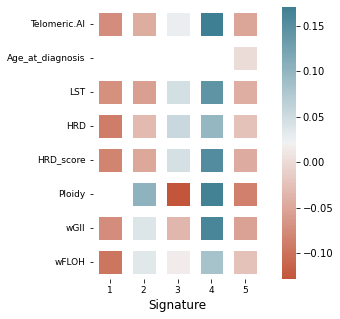

In [20]:
palette = sns.diverging_palette(20, 220, as_cmap=True)

f, ax = plt.subplots(figsize=(7, 5))
ax = sns.heatmap(
    corr_df[corr_df!=0],
    # vmin=-0.5, vmax=0.5, 
    cmap=palette,
    square=True,
    linewidths=11)
    
plt.xlabel("Signature", fontsize=12)
ax.tick_params(axis="both", which="major", labelsize=9)
plt.savefig('../figures/correlation_matrix_tweak.pdf')